In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.1.0'

In [0]:
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np


def read_image(file, bounds):
    image = open_image(file, bounds)
    image = normalize_image(image)
    return image


def open_image(file, bounds):
    image = Image.open(file)
    image = image.crop(bounds)
    image = image.resize((64, 64))
    return np.array(image)


# Normalization, [-1,1] Range
def normalize_image(image):
    image = np.asarray(image, np.float32)
    image = tf.image.resize(image, (64, 64))
    image = image / 127.5 - 1
    return img_to_array(image)


# Restore 0..255 Range
def denormalize_image(image):
    return ((image+1)*127.5).astype(np.uint8)

In [4]:
import shutil
import os

import numpy as np
import xml.etree.ElementTree as et
from tensorflow.keras.preprocessing.image import array_to_img
import tensorflow_datasets as tfds 
from matplotlib import pyplot as plt
from numpy import save

def generate_noise(size):
    return np.random.normal(0, 1, size=[size, INPUT_SIZE])

def load_images():  
    #split = tfds.Split.TRAIN.subsplit([100])
    # split = tfds.Split.TRAIN.subsplit([90, 10])
    # training_set = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split="train")
    # train_images = [normalize_image(image[0]) for image in training_set]
    ds_train = tfds.load(name="cats_vs_dogs", split="train", shuffle_files=True)
    train_images = [normalize_image(features["image"]) for features in ds_train.take(24000)]
    print(np.array(train_images).shape)
    save('train_images.npy', np.array(train_images))
    #return np.array(train_images)


def save_images(generator):
    if not os.path.exists('output'):
        os.mkdir('output')

    noise = generate_noise(10000)
    generated_images = generator.predict(noise)

    for i in range(generated_images.shape[0]):
        image = denormalize_image(generated_images[i])
        image = array_to_img(image)
        image.save( 'output/' + str(i) + '.png')

    shutil.make_archive('images', 'zip', 'output')

load_images()

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompletePT4LFF/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
(23262, 64, 64, 3)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import matplotlib.pyplot as plt
from numpy import save


def generate_noise(size):
    return np.random.normal(0, 1, size=[size, 100])


def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  save('np'+str(epoch), predictions)
  

In [0]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, \
    BatchNormalization, UpSampling2D, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers
def make_generator_model():
   
    model = tf.keras.Sequential()
    model.add(layers.Dense(units=512 * 8 * 8, input_shape=(100,)))
    model.add(layers.Reshape((8, 8, 512)))

    model.add(layers.Conv2DTranspose(512, 4, strides=1, activation='relu', padding='same'))
    model.add(layers.BatchNormalization(momentum=0.1, epsilon=1e-05))

    model.add(layers.Conv2DTranspose(256, 4, strides=2, activation='relu', padding='same'))
    model.add(layers.BatchNormalization(momentum=0.1, epsilon=1e-05))

    model.add(layers.Conv2DTranspose(128, 4, strides=2, activation='relu', padding='same'))
    model.add(layers.BatchNormalization(momentum=0.1, epsilon=1e-05))

    model.add(layers.Conv2DTranspose(64, 4, strides=2, activation='relu', padding='same'))
    model.add(layers.BatchNormalization(momentum=0.1, epsilon=1e-05))

    model.add(layers.Conv2DTranspose(3, 4, strides=1, activation='tanh', padding='same'))
  
    return model
   


def make_discriminator_model():

    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(64, 64, 3)))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(512, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(1, kernel_size=4, strides=1, padding='same'))

    model.add(layers.Flatten())
    model.add(layers.Dense(units=1, activation='sigmoid'))

    return model

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [0]:
generator = make_generator_model()
discriminator = make_discriminator_model()


generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [23]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             3309568   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         4194816   
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 512)         2048      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 256)       2097408   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 128)       5

In [24]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         524544    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 512)        

In [0]:
from numpy import load
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


EPOCHS = 400
noise_dim = 100
BUFFER_SIZE = 2000
num_examples_to_generate = 100
BATCH_SIZE = 32
images = load('train_images.npy')
train_images = np.array(images)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

y_valid = np.ones(BATCH_SIZE)*0.9
y_fake = np.zeros(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
import time
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from numpy import load
from tensorflow.keras.optimizers import Adam, SGD
from IPython import display
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    
    for image_batch in dataset:      
        train_step(image_batch)
 
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 10 epochs
    if (epoch + 1) % 10 == 0:
      print("saving checkpoint...")
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [20]:
train(train_dataset, EPOCHS)

Time for epoch 331 is 67.72065424919128 sec


KeyboardInterrupt: ignored

(100, 64, 64, 3)


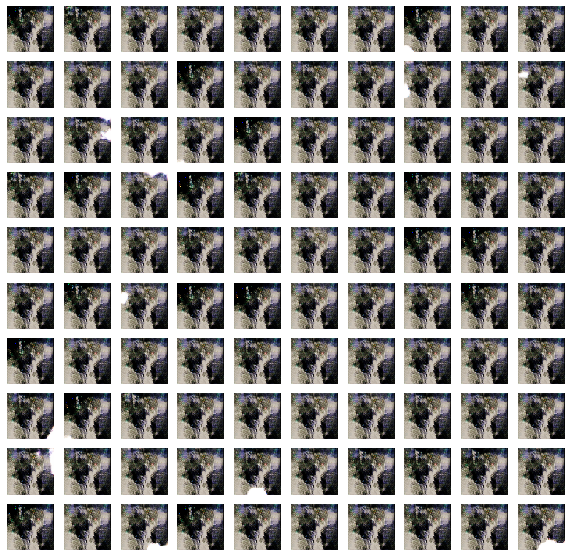

In [22]:
#show just one figure from arbitrary epoch
from numpy import load
images = load('np330.npy')
print(images.shape)
figsize = (10,10)
dim=(10,10)
plt.figure(figsize=figsize)
for i in range(images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(denormalize_image(images[i]), interpolation='nearest')
    plt.axis('off')

In [2]:
#show gif
from numpy import load
figsize = (10,10)
dim=(4,4)
plt.figure(figsize=figsize)
filenames = glob.glob('np*.npy')
filenames = sorted(filenames)
last = -1
for j,filename in enumerate(filenames):
  images = images = load(filename)
  for i in range(images.shape[0]):
      plt.subplot(dim[0], dim[1], i+1)
      plt.imshow(denormalize_image(images[i]), interpolation='nearest')
      plt.axis('off')
  print('working on '+str(j)+'th np file,'+' file name is:'+filename)
  
  plt.tight_layout()
  plt.savefig('image1' + str(j) + '.png')

print("building gif file...")
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image1*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

NameError: ignored

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
seed = tf.random.normal([100, noise_dim])
predictions = generator(seed, training=False)
Name = 'npFile'
save(Name, predictions)
images = load(Name+'.npy')
print(images.shape)
figsize = (10,10)
dim=(10,10)
plt.figure(figsize=figsize)
for i in range(images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(denormalize_image(images[i]), interpolation='nearest')
    plt.axis('off')